#Carregar Libs

- Preprocessing: data load/augmentation, transformação de dados
- Otimizadores
- Layers e Models: componentes da rede e funções de composição e produção de variáveis (input).  Banco de modelos (applications).
- Backends 
- Callbacks: salvar modelo em meio a execução(checkpoint), agendar mudança de parametros e visualizar grafo de computação

In [90]:
# Importing basic Python Modules to data container, computation and visualization 
import numpy as np
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

# Importing Tensorflow, python API.
import tensorflow as TF
from tensorflow.compat.v1.graph_util import convert_variables_to_constants

# Importing Keras API, high level Python Tensorflow API with extra functionalities
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras import applications
from keras.models import Sequential, Model, Input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard as Board, EarlyStopping

# Installing newest Lucid version and  Importing Lucid, some imports are because of explicity hacks in Lucid functions

#!pip install --quiet lucid==master
!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git
import lucid.modelzoo.vision_models as models
from lucid.modelzoo.vision_base import Model
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
from lucid.optvis.render import import_model, make_transform_f, make_optimizer, gradient_override_map, redirected_relu_grad, redirected_relu6_grad, make_print_objective_func
import lucid.optvis.transform as transform
from tensorflow.train import AdamOptimizer as Adam

### Functions bellow are being hacked on purpose for this research, uncomment, see the original in the repo pls
#fft_image = param.spatial.fft_image
#rfft2d_freqs = param.spatial.rfft2d_freqs
#to_valid_rgb = param.color.to_valid_rgb
#from lucid.optvis.render import make_vis_T


# For Tensorboard Visualization on web, use ipython display functionalities
from IPython.display import clear_output, Image, display, HTML

# Reset Tensorflow session and its graph definition, clear namespaces
clear = lambda: os.system('clear')
def reset_session(sess, clear_namespace = True):
  TF.reset_default_graph()
  sess.close()  
  if clear_namespace:
    clear()

#Data Load/Augmentation

- flow_from_dir without any arg and ``` classes = [" "] ``` will load the entire image dataset.

In [36]:
# Data load, but without augmentation. You can use ImageDataGenerator arguments to do augmentation if you desire.
data_gen = ImageDataGenerator()
dataload_dir = data_gen.flow_from_directory('/content/',target_size=(512,512), classes = [''], batch_size= 1)

# So ... the generator must yeld the next [batch,class_label] dataset
batch0 = dataload_dir.next()

## Batch0 contains batchs of data and the corresponding class label. We will be using only the data batches
# so batch correspond only to batches without classes. 
batch = batch0[0]

Found 2 images belonging to 1 classes.


In [37]:
print(np.shape(batch))

(1, 512, 512, 3)


##**Display Image-Data-Set**
- The first of the ndarray (tensor) batch holds for the dataset sample.
- We are using RGB function from Matplotlib, to use this you must use the three channels of the batch tensor, the last index, they hold for RGB. They must be int.


In [0]:
# TODO - viz de todo o batch
def show_rgb_withchannels(batch,j):
  fig = plt.figure()
  u0,d0,l0,r0 = 0.1,0.1,0.8,0.8  
  u,d,l,r = [0.0,0.0,0.0,0.0]
  #for i in range(np.shape(batch)[0]):
  u,d,l,r = [u+u0,d+d0,l+l0,r+r0]
  ax = RGBAxes(fig,[u,d,l,r])
  ax.imshow_rgb(np.int32(batch[j,:,:,0]),np.int32(batch[j,:,:,1]),np.int32(batch[j,:,:,2]),interpolation='none')

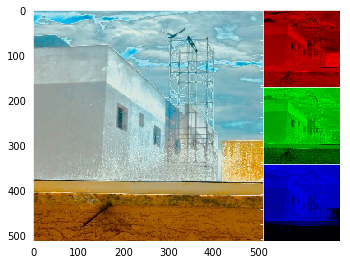

In [35]:
show_rgb_withchannels(batch,0)

#Transfer-Learning
- Load Model VGG19 trained in ImageNet dataset. 
- Freeze Tensorflow Graph Computation session to save model definition (.pb extension files).

##Extract Network Layers
 1.   Build New Model in what will be transfered network layers.
 2.   Replace the model layers built with the pre-trained loaded model in the first step.
 
##Train New Model
 1. Stack New Layers upon the transfered model and train it from scratch.








**Functions Definitions**

In [0]:
# Freezing graph in Tensorflow session. Required to write graph definitions to further reuse.

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.    
    
    Parameters:
    
    - session: The TensorFlow session to be frozen.
    
    Default Keyword Parameters
    
    - keep_var_names: A list of variable names that should not be frozen. Defaults None.     
    - output_names: Names of the relevant graph outputs/operation/tensor to be written. Defaults None.
    - clear_devices: Remove the device directives from the graph for better portability. Defaults True.
    
    return The frozen graph definition.
    """    
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in TF.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in TF.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph     



def get_tensors(model):
  """
  Useful function, output tensors of a model
  """
  with TF.Graph().as_default() as graph, TF.Session().as_default() as sess:  
    graphdef = model.graph_def
    TF.import_graph_def(graphdef,{model.input_name:TF.placeholder(TF.float32, name = model.input_name)})
    TF.initialize_local_variables()
    graphdef.node
    
    return [op.name for op in graph.get_operations()]  

**Load Model , Freeze Session and Write Model**

>We will be using Keras direct support to trained VGG19, however you can load any pre-trained model compressed in a h5py file. Be sure to initiallize the optmizator (through the .compile function) SGD or whatever it may be.

In [0]:
# Save model in .pb to load model as graph and to visualize it with Lucid.
# TODO: how to save model definition .pb when it were loaded with Lucid.
with TF.Graph().as_default() as graph, TF.Session() as sess:  
  
    model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (512, 512, 3))    
    frozen_graph = freeze_session(sess, output_names= None)
    TF.train.write_graph(frozen_graph, "model", "./Model.pb", as_text=False)   

In [94]:
# Load the Saved-Model and show graph, 
# Define model with input placeholder information. Use Model inheritance to do so, using load_graphdef() function, to use Model.pb graphdef

# You must define a model to be loaded from outside the modelzoo 
class VGG(Model):
  model_path = '/content/model/Model.pb'
#  image_shape = (1,512, 512, 3)
#  image_value_range = (0.0, 255.0)
  input_name = 'input_1'
#  def __init__(self):
#    with TF.Graph().as_default() as graph, TF.Session() as sess:
#      t_input = TF.placeholder(np.float32, name='input_1') # define the input tensor
#      imagenet_mean = 117.0
#      t_preprocessed = TF.expand_dims(t_input - imagenet_mean, 0)          
     

  
# Load model from VGG outside modelzoo from .pb, this case used from keras applications.
# Load model from modelzoo, Inception, only change input_name
#model = VGG()
model = models.InceptionV1()
model.image_shape = (1,512, 512, 3)
model.image_value_range = (0.0, 255.0)
model.input_name = 'input'
model.load_graphdef()
model.show_graph()



##Visualization of a Feature Channel of Hidden Layer
  - Using Lucid to do ease to build feature visualizations
  - Attribuition function with fft cleaning
  .

**Functions Definitions**

- Hacking Lucid render functions
- Attribuition function with fourier filtering.

In [0]:
### Functions Definition.
## Hacking Lucid functions to proper use.

def pixel_image(init_val, sd=None):
  """A naive, pixel-based image parameterization.
  Defaults to a random initialization, but can take a supplied init_val argument
  instead.
  Args:
    shape: shape of resulting image, [batch, width, height, channels].
    sd: standard deviation of param initialization noise.
    init_val: an initial value to use instead of a random initialization. Needs
    to have the same shape as the supplied shape argument.
  Returns:
    tensor with shape from first argument.
    
    TODO - Noise mask.
  """
  if sd is not None and init_val is not None:
        warnings.warn(
          "`pixel_image` received both an initial value and a sd argument. Ignoring sd in favor of the supplied initial value."
      )

  sd = sd or 0.01
  
  return TF.Variable(init_val, dtype=TF.float32)

def fft_image(init_val, sd=None, decay_power=1, filtersize = 0.3, display_spectrum = None):
    """An image paramaterization using 2D Fourier coefficients."""

    sd = sd or 0.01
    
    batch, h, w, ch = np.shape(init_val)
    #freqs = rfft2d_freqs(h, w)
    #init_val_shape = (2, ch) + freqs.shape
    
    images = []
    for _ in range(batch):
        # Create a random variable holding the actual 2D fourier coefficients
        fourierspect = np.fft.fft2(init_val[_]).astype(np.complex64)
        fs = fourierspect.copy()
        fourierspect[ int(h*filtersize):int(h*(1-filtersize)) ,int(w*filtersize):int(w*(1-filtersize))] = 0          

        # Scale the spectrum. First normalize energy, then scale by the square-root
        # of the number of pixels to get a unitary transformation.
        # This allows to use similar leanring rates to pixel-wise optimisation.

        #scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
        #scale = 1.0/np.sqrt(w * h)
        #scaled_spectrum_t =  spectrum_real_imag_t
        spect = np.fft.ifft2(fourierspect)        
        
        def plot_spectrum(im_fft):
          from matplotlib.colors import LogNorm
        # A logarithmic colormap                    
          plt.figure()
          plt.imshow(np.abs(im_fft/255.0))
          plt.colorbar()
          plt.title('Fourier transform')
          plt.show()          
        if type(display_spectrum) != type(None):
          plot_spectrum(fs)     
        
        # convert complex scaled spectrum to shape (h, w, ch) image tnpensor
        # needs to transpose because irfft2d returns channels first
        image_t = TF.Variable( spect.real , dtype=TF.float32)        
        # in case of odd spatial input dimensions we need to crop
        image_t = image_t[:h, :w, :ch]        
        images.append(image_t)        
    batched_image_t = TF.stack(images)  # TODO: is that a magic constant?
    return batched_image_t

def make_t_image(init_val, param_f, pixel = False):
  
  if param_f is None or param_f == "random":
    #print('gray')
    t_image = fft_image(init_val, sd= None, decay_power = 1) 
    #t_image = to_valid_rgb(t_image[..., :3], decorrelate=False, sigmoid=True)
  else:   
    #print('image')
    if pixel:        
      t_image = pixel_image(init_val, sd=None)
    else:        
      t_image = fft_image(init_val, sd= None, decay_power = 1) 
    #t_image = to_valid_rgb(t_image[..., :3], decorrelate=True, sigmoid=True)
      
  #if callable(param_f):
  #  t_image = param_f()
  #elif isinstance(param_f, TF.Tensor):
  #  t_image = param_f
  #else:
  #  print('foo')
    #raise TypeError("Incompatible type for param_f, " + str(type(param_f)) )
  #if not isinstance(t_image, TF.Tensor):
  #  raise TypeError("param_f should produce a Tensor, but instead created a "
  #                 + str(type(t_image)) )
  #elif t_image.graph != TF.get_default_graph():
  #  raise TypeError("""param_f produced a t_image tensor belonging to a graph
  #                   that isn't the default graph for rendering. Did you
  #                   accidentally use render_vis when you meant to use
  #                   make_vis_T?""")
  #else:
  return t_image

def make_vis_T(model, objective_f, param_f=None, init_val = None, optimizer=None,
               transforms=None, relu_gradient_override=False, pixel = False):
  """Even more flexible optimization-base feature vis.
  This function is the inner core of render_vis(), and can be used
  when render_vis() isn't flexible enough. Unfortunately, it's a bit more
  tedious to use:
  >  with tf.Graph().as_default() as graph, tf.Session() as sess:
  >
  >    T = make_vis_T(model, "mixed4a_pre_relu:0")
  >    tf.initialize_all_variables().run()
  >
  >    for i in range(10):
  >      T("vis_op").run()
  >      showarray(T("input").eval()[0])
  This approach allows more control over how the visualizaiton is displayed
  as it renders. It also allows a lot more flexibility in constructing
  objectives / params because the session is already in scope.
  Args:
    model: The model to be visualized, from Alex' modelzoo.
    objective_f: The objective our visualization maximizes.
      See the objectives module for more details.
    param_f: Paramaterization of the image we're optimizing.
      See the paramaterization module for more details.
      Defaults to a naively paramaterized [1, 128, 128, 3] image.
    optimizer: Optimizer to optimize with. Either tf.train.Optimizer instance,
      or a function from (graph, sess) to such an instance.
      Defaults to Adam with lr .05.
    transforms: A list of stochastic transformations that get composed,
      which our visualization should robustly activate the network against.
      See the transform module for more details.
      Defaults to [transform.jitter(8)].
  Returns:
    A function T, which allows access to:
      * T("vis_op") -- the operation for to optimize the visualization
      * T("input") -- the visualization itself
      * T("loss") -- the loss for the visualization
      * T(layer) -- any layer inside the network
  """

  # pylint: disable=unused-variable
  if type(init_val) == type(None):
    shape = tuple(model.image_shape)
  elif type(model.image_shape) == type(None):    
    shape = (1, 128, 128, 3)
  elif len(model.image_shape) < 4:
    shape = (1, 128, 128, 3)
  else:
    shape = np.shape(init_val)  
  
  t_image = make_t_image(init_val, param_f, pixel = pixel)
  objective_f = objectives.as_objective(objective_f)
  transform_f = make_transform_f(transforms)
  if type(optimizer) == type(None):
    optimizer = Adam(learning_rate = 0.8)
  optimizer = make_optimizer(optimizer, [])

  global_step = TF.train.get_or_create_global_step()
  init_global_step = TF.variables_initializer([global_step])
  init_global_step.run()

  if relu_gradient_override:
    with gradient_override_map({'Relu': redirected_relu_grad,
                                'Relu6': redirected_relu6_grad}):      
      T = import_model(model, t_image, t_image)
  else:
    T = import_model(model, t_image, t_image)
  loss = objective_f(T)
  
  vis_op = optimizer.minimize(-loss, global_step=global_step)

  local_vars = locals()
  # pylint: enable=unused-variable

  def T2(name):
    if name in local_vars:
      return local_vars[name]
    else: return T(name)

  return T2

def render_vis(model, objective_f, param_f=None, optimizer=None,
               transforms=None, thresholds=(512,), print_objectives=None,
               verbose=True, relu_gradient_override=True, use_fixed_seed=False):
  """Flexible optimization-base feature vis.
  There's a lot of ways one might wish to customize otpimization-based
  feature visualization. It's hard to create an abstraction that stands up
  to all the things one might wish to try.
  This function probably can't do *everything* you want, but it's much more
  flexible than a naive attempt. The basic abstraction is to split the problem
  into several parts. Consider the rguments:
  Args:
    model: The model to be visualized, from Alex' modelzoo.
    objective_f: The objective our visualization maximizes.
      See the objectives module for more details.
    param_f: Paramaterization of the image we're optimizing.
      See the paramaterization module for more details.
      Defaults to a naively paramaterized [1, 128, 128, 3] image.
    optimizer: Optimizer to optimize with. Either tf.train.Optimizer instance,
      or a function from (graph, sess) to such an instance.
      Defaults to Adam with lr .05.
    transforms: A list of stochastic transformations that get composed,
      which our visualization should robustly activate the network against.
      See the transform module for more details.
      Defaults to [transform.jitter(8)].
    thresholds: A list of numbers of optimization steps, at which we should
      save (and display if verbose=True) the visualization.
    print_objectives: A list of objectives separate from those being optimized,
      whose values get logged during the optimization.
    verbose: Should we display the visualization when we hit a threshold?
      This should only be used in IPython.
    relu_gradient_override: Whether to use the gradient override scheme
      described in lucid/misc/redirected_relu_grad.py. On by default!
    use_fixed_seed: Seed the RNG with a fixed value so results are reproducible.
      Off by default. As of tf 1.8 this does not work as intended, see:
      https://github.com/tensorflow/tensorflow/issues/9171
  Returns:
    2D array of optimization results containing of evaluations of supplied
    param_f snapshotted at specified thresholds. Usually that will mean one or
    multiple channel visualizations stacked on top of each other.
  """

  with TF.Graph().as_default() as graph, TF.Session() as sess:

    if use_fixed_seed:  # does not mean results are reproducible, see Args doc
      tf.set_random_seed(0)

    T = make_vis_T(model, objective_f, param_f, optimizer, transforms,
                   relu_gradient_override)
    print_objective_func = make_print_objective_func(print_objectives, T)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")
    TF.global_variables_initializer().run()

    images = []
    try:
      for i in range(max(thresholds)+1):
        loss_, _ = sess.run([loss, vis_op])
        if i in thresholds:
          vis = t_image.eval()
          images.append(vis)
          if verbose:
            print(i, loss_)
            print_objective_func(sess)
            show(np.hstack(vis))
    except KeyboardInterrupt:
      log.warning("Interrupted optimization at step {:d}.".format(i+1))
      vis = t_image.eval()
      show(np.hstack(vis))

    return images
  
def attribution0(batch, objective, optmization_steps = 20, with_fft = True, fft_steps = 10, display_original = False, **kwargs):
  """
  This function fits given image to an objective, what can be channel, mix of channel, layers and so on.
  It does so through optimization of hidden objective in relation to given image. You can apply fft denoising 
  after a number of optimization steps. In the end it displays the original image and the one optimized to the
  objective.
  
  kwargs
  --optmization_steps: an integer that determines the number of optimization steps in relation to the objective
  before taking a fft denoising tranform on the input. Defaults to 20.  
  --with_fft: boolean. Determines if the algorithm is to do denoising.
  --fft_steps: Integer. Determines how many steps it will apply denoise after optimization steps.
  --display_original: shows the original input before the optimization togheter with the output.
  
  ps: The total number of optimization steps in order to attribute an input to an objective is:
    N = optimization_steps*fft_steps
    Even if you choose to not do denoising however set fft_steps to non zero value.
  """   
  if 'verbose' in kwargs:
    verbose = kwargs['verbose']
  else:
    verbose = False
    
  if 'param_f' in kwargs:
    param_f = kwargs['param_f']
  else:
    param_f = None
  if 'std' in kwargs:
    std = kwargs['std']
  else:
    std = 1.
  
  
  if (param_f == 'random') or type(batch) == type(None):
    batch = np.random.uniform(0, std, model.image_shape) + 117.0
  
  if display_original and (param_f != 'random') and type(batch) != type(None):
    bout = batch.copy()  
  
  for j in range(fft_steps):  
    if verbose:
      print('denoise step:', j)   
    with TF.Graph().as_default() as graph, TF.Session() as sess:
    
      TF.set_random_seed(237)
    
      if j == 0 or (not with_fft):
        T = make_vis_T(model, obj, param_f = param_f, init_val = batch, relu_gradient_override = True, pixel = True)
      else:  
        T = make_vis_T(model, obj, param_f = param_f, init_val = batch, relu_gradient_override = True)
      TF.initialize_all_variables().run()
      for i in range(optmization_steps):
        T("vis_op").run()
        if verbose:
          print("Loss ",T("loss").eval())          
      
      batch = T("input").eval()
  
  if display_original and (param_f != 'random') and type(batch) != type(None):   
    plt.figure(dpi=150)
    plt.imshow(bout[0,...].astype(np.int32))
    plt.show()
    
  plt.figure(dpi=150)    
  plt.imshow((batch[0]).astype(np.int32))
  plt.show()
  #show(batch[0,...], domain=(0,255))

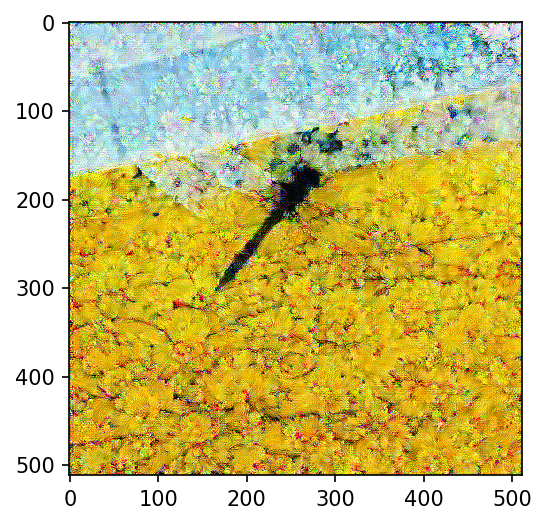

In [0]:
## Test attribuition function with many objectives

channel = lambda n: objectives.channel("mixed4d_3x3_bottleneck_pre_relu", n)
#otherlayerchannel = lambda n: objectives.channel("block3_conv3/convolution", n)


#obj = channel(511) + channel(311) + channel(411) + channel(111) + channel(481) + channel(221) + channel(11) + channel(90) + otherlayerchannel(20) + otherlayerchannel(30) + otherlayerchannel(55) + otherlayerchannel(80) + otherlayerchannel(90) + otherlayerchannel(120)
obj = channel(139)

batch = batch0[0]
#batch = None
#attribution0(batch,obj, optmization_steps = 512, fft_steps = 1, with_fft= False, verbose = True, param_f = 'random')
#attribution0(batch,obj, optmization_steps = 20, with_fft= True, fft_steps = 25, verbose = False, param_f = 'random')
attribution0(batch,obj, optmization_steps = 1012, fft_steps = 1, with_fft= False, verbose = False)
attribution0(batch,obj, optmization_steps = 20, with_fft= True, fft_steps = 500, display_original = True, verbose = False)

In [0]:
####
###
# Some visualization hacked from deep-dreams, comparing the Lucid hacking with the deep-dreams hack. Multiscale hacking
##
###

from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from google.colab import files
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
#layer = 'import/block5_conv4/convolution'
layer = "import/mixed4d_3x3_bottleneck_pre_relu"
layer1 = "import/mixed4c_3x3_bottleneck_pre_relu"


# start with a gray image with a little noise
img_noise0 = np.random.uniform(size=(1,512,512,3)) + 100.0
img_noise = batch0[0] 

with TF.Graph().as_default() as graph, TF.Session().as_default() as sess:  
  model.load_graphdef()
  graph_def = model.graph_def
  """
  with TF.gfile.GFile(model_fn, 'rb') as f:
    graph_def = TF.GraphDef()
    graph_def.ParseFromString(f.read())
  t_input = TF.placeholder(np.float32, name='input') # define the input tensor
  imagenet_mean = 117.0
  #t_preprocessed = TF.expand_dims(t_input, 0)"""
  t_input = TF.placeholder(np.float32, name='input')
  t_preprocessed = TF.expand_dims(t_input, 0)
  TF.import_graph_def(graph_def, {'input':t_preprocessed} )

  def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save('/content/Inception139_100_4d_4c_3x.jpeg', fmt)
    files.download('/content/Inception139_100_4d_4c_3x.jpeg')
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
  def visstd(a, s=0.3):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

  def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("%s:0"%layer)

  def calc_grad_tiled(img, t_grad, tile_size=1024):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
      for x in range(0, max(w-sz//2, sz),sz):
        sub = img_shift[y:y+sz,x:x+sz]
        g = sess.run(t_grad, {t_input:sub})
        grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

  def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(TF.placeholder, argtypes))
    def wrap(f):
      out = f(*placeholders)
      def wrapper(*args, **kw):
        return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
      return wrapper
    return wrap

# Helper function that uses TF to resize an image
  def resize(img, size):
    img = TF.expand_dims(img, 0)
    return TF.image.resize_bilinear(img, size)[0,:,:,:]
  
  resize = tffunc(np.float32, np.int32)(resize)


  def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
      for x in range(0, max(w-sz//2, sz),sz):
        sub = img_shift[y:y+sz,x:x+sz]
        g = sess.run(t_grad, {t_input:sub})
        grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

  def render_multiscale(t_obj, img0=img_noise, iter_n=256, step=.8, octave_n=3, octave_scale=2.5):
    t_score = TF.reduce_mean(t_obj) # defining the optimization objective
    t_grad = TF.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
      if octave>0:
        hw = np.float32(img.shape[:2])*octave_scale
        img = resize(img, np.int32(hw))
      for i in range(iter_n):
        g = calc_grad_tiled(img, t_grad)
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print('.', end = ' ')
      clear_output()
      showarray(visstd(img))

  render_multiscale(T(layer)[:,:,:,139]+T(layer1)[:,:,:,100], img0 = img_noise[0])
  #render_multiscale(T(layer)[:,:,:,139]+T(layer1)[:,:,:,120], img0 = img_noise0[0])


##Extract Network Layers

###1. Build New Model
 >For this we will be using usual Keras interface for 2D Convolutional Nets with Max Pooling. This Network will be receiving the first layers of VGG19 ImageNet Pre-Trained Network.


In [0]:
img_width, img_height = 2050, 2050

### Build the network 
# Block 1
img_input = Input(shape=(img_width, img_height, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

newmodel = Model(input = img_input, output = x)

newmodel.summary()

In [0]:
# Dictionary using tuples layer name-weights
layer_dict = dict([(layer.name, layer) for layer in newmodel.layers])
layer_names = [layer.name for layer in newmodel.layers]

###2. Replace the Model-Layers
>

In [0]:
for i in layer_dict.keys():    
    index = layer_names.index(i)    
    for j in model.layers:       
        if i == j.name:           
            w = model.layers[model.layers.index(j)]
            newmodel.layers[index].set_weights(w.get_weights())            

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    tinput = tf.get_variable('tensor_input1', initializer= batch)

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    modeloleitura = newmodel.call(tinput)

In [0]:
modeloleitura.get_shape()

TensorShape([Dimension(6), Dimension(512), Dimension(512), Dimension(128)])

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    nptensor = modeloleitura.eval(session=sess)
  


In [0]:
sess.close()

##Train New Model

###1. Stack New Layers 
> Add new layers with Keras Interface to train your model.


In [0]:
img = load_img('anny0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [0]:
# Generates Batch of Data
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./', save_prefix='anny', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [0]:
img = load_img('/content/anny_0_1461.jpeg')  # this is a PIL image
x0 = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x0 = x0.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [0]:
img_width, img_height = 1543, 1062

### Build the network 
img_input = Input(shape=(1543, 1062, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

model = Model(input = img_input, output = x)

model.summary()
"""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
=================================================================
Total params: 260,160.0
Trainable params: 260,160.0
Non-trainable params: 0.0
"""

layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]
"""
['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool']
"""


NameError: ignored

In [0]:

import h5py
weights_path = 'vgg19_weights.h5' # ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5)
f = h5py.File(weights_path)

list(f["model_weights"].keys())
"""
['block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'dense_1',
 'dense_2',
 'dense_3',
 'dropout_1',
 'global_average_pooling2d_1',
 'input_1']
"""

# list all the layer names which are in the model.
layer_names = [layer.name for layer in model.layers]


"""
# Here we are extracting model_weights for each and every layer from the .h5 file
>>> f["model_weights"]["block1_conv1"].attrs["weight_names"]
array([b'block1_conv1/kernel:0', b'block1_conv1/bias:0'], 
      dtype='|S21')
# we are assiging this array to weight_names below 
>>> f["model_weights"]["block1_conv1"]["block1_conv1/kernel:0]
<HDF5 dataset "kernel:0": shape (3, 3, 3, 64), type "<f4">
# The list comprehension (weights) stores these two weights and bias of both the layers 
>>>layer_names.index("block1_conv1")
1
>>> model.layers[1].set_weights(weights)
# This will set the weights for that particular layer.
With a for loop we can set_weights for the entire network.
"""
for i in layer_dict.keys():
    weight_names = f["model_weights"][i].attrs["weight_names"]
    weights = [f["model_weights"][i][j] for j in weight_names]
    index = layer_names.index(i)
    model.layers[index].set_weights(weights)

    
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import glob

features = []
for i in tqdm(files_location):
        im = cv2.imread(i)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        outcome = model_final.predict(im)
        features.append(outcome)
        
## collect these features and create a dataframe and train a classfier on top of it.